# Image Retrieval

In [1]:
import cv2
import numpy as np
import faiss
from glob import glob
import matplotlib.pyplot as plt
import os
import unicom
import torch

from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.nn.functional import normalize

c:\Users\swan\anaconda3\envs\yolov8-py38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(2048)
model, preprocess = unicom.load("ViT-B/32")
#model = model.cuda()
model.eval()

@torch.no_grad()
def get_features(dataset):
    all_features = []
    for images, _ in tqdm(DataLoader(dataset, batch_size=32, num_workers=8)):
        features = model(images)
        #features = model(images.cuda())
        all_features.append(features)
    return torch.cat(all_features)

### Faiss 인덱스 빌드 및 이미지 검색

In [3]:
import faiss
import numpy as np
from dataloader import Car

# PyTorch Tensor를 NumPy 배열로 변환
gallery_embedding = torch.from_numpy(np.load('./unicom+ViT-B32/hyundai_cars131_gallery_cpu.npy'))

# gallery = Car("./data/hyundai_cars131_original/", transform=preprocess)
# gallery_embedding = get_features(gallery)

# # Faiss 인덱스 생성
# d = gallery_embedding.shape[-1]
# index = faiss.IndexFlatL2(d)  # L2 거리를 사용하는 인덱스 생성

# # 인덱스에 벡터 데이터 추가
# index.add(gallery_embedding)

# 유사한 벡터 검색
# query_embedding = torch.from_numpy(np.load('./unicom+ViT-B32/hyundai_cars131_query05_cpu.npy'))
query = Car("./data/query/", transform=preprocess)
query_embedding = get_features(query)
# k = 6  # 반환할 가장 가까운 벡터의 수
# score, index = index.search(query_embedding, k)  # 거리와 해당 벡터의 인덱스 반환
cosine = query_embedding @ gallery_embedding.T  # 각 ID에 대해 test 임베딩의 cosine 유사도 계산
score, index = torch.sort(cosine, descending=True)  # 내림차순으로 정렬

  0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\swan\anaconda3\envs\yolov8-py38\lib\site-packages\torch\utils\checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
c:\Users\swan\anaconda3\envs\yolov8-py38\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
100%|██████████| 1/1 [00:06<00:00,  6.42s/it]


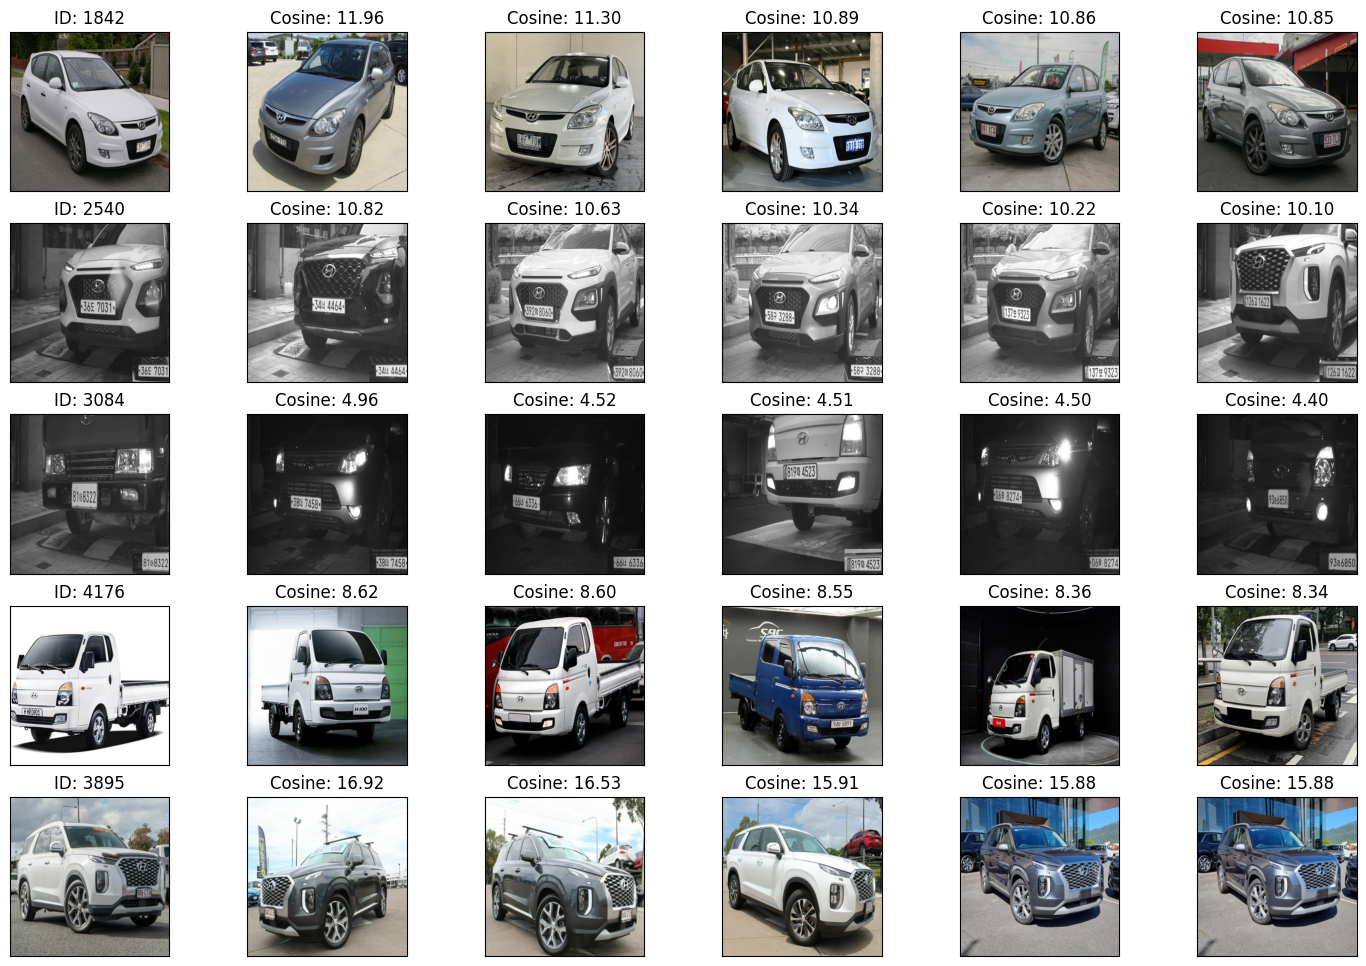

: 

In [4]:
gallery_wo_transform = Car("./data/hyundai_cars131_original", transform=None)
plt.figure(figsize=(24, 12))

qn = len(os.listdir('./data/query/'))
for row in range(0, qn):  # 다중검색 -> len(query[0])
    for col in range(0, 6):  # top-5
        idx = index[row][col]
        if col == 0:
            title = f"ID: {idx}"
        else:
            title = f"Cosine: {score[row][col] :.2f}"

        image = gallery_wo_transform[idx][0].convert("RGB")
        plt.subplot(qn, 8, row * 8 + col + 1, fc='b')
        plt.imshow(image.resize((300, 300)))
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

### 임베딩 저장

In [12]:
import numpy as np

np.save('./unicom+ViT-L14@336px/hyundai_cars131_query05_cpu.npy', np.array(query_embedding))